# Total Competition
Stacked bar plots of Formula 1 constructors' points from https://ergast.com/mrd/db

In [1]:
%autosave 0

from etl import DATADIR, ErgastF1
from viz import Plot

f1 = ErgastF1(DATADIR / 'ergast/f1.zip')
plot = Plot()

Autosave disabled


## Which teams scored the most points?
Get points for each (race, team) for all available races.

In [2]:
points = (
    f1.team_results
    .join(f1.races, how='inner', on='id_race')
    .join(f1.teams['team'], on='id_team')
    .sort_values('date')
    ['season race team points'.split()]
    .reset_index(drop=True)
)
points

,season,race,team,points
0,1956,Argentine Grand Prix,Maserati,13.0
1,1956,Argentine Grand Prix,Ferrari,12.0
2,1956,German Grand Prix,Gordini,0.0
3,1956,German Grand Prix,Maserati,15.0
4,1956,German Grand Prix,Ferrari,9.0
...,...,...,...,...
11555,2019,Abu Dhabi Grand Prix,McLaren,5.0
11556,2019,Abu Dhabi Grand Prix,Toro Rosso,2.0
11557,2019,Abu Dhabi Grand Prix,Renault,0.0
11558,2019,Abu Dhabi Grand Prix,Alfa Romeo,0.0


In [3]:
from collections import defaultdict

color = {
    'BAR': '#77bb77',
    'Benetton': '#00bb00',
    'BMW Sauber': '#bbbbbb',
    'Brawn': '#bbff00',
    'Ferrari': "#ff0000",
    'McLaren': "#ffbb00",
    'Mercedes': '#00ffff',
    'Red Bull': '#330077',
    'Renault': '#00bbff',
    'Williams': '#0000ff',
    'Jordan': '#ffff00'
}
color = defaultdict(lambda: '#000000', color)

## the colors of money
A few well-funded teams usually score most of the points each year.

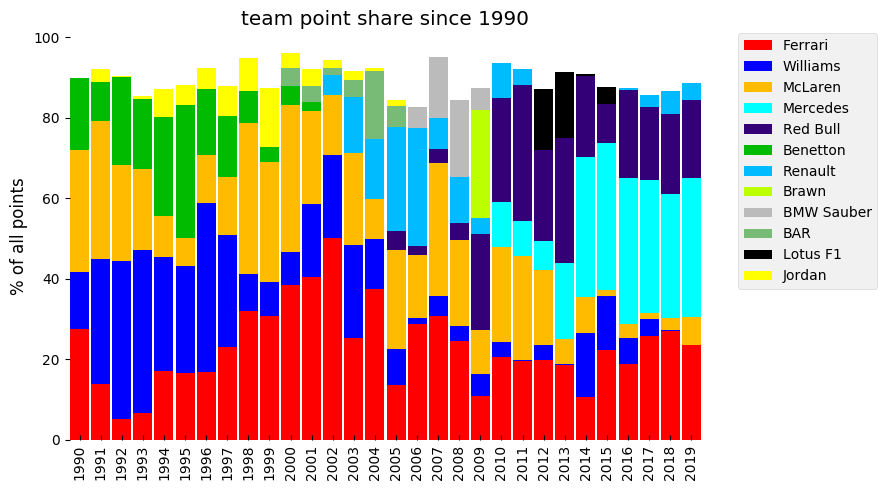

In [4]:
def top12since(year, **kwargs):

    data = (
        points.loc[lambda df: df['season'].ge(year)]
        .groupby('season team'.split(), sort=False)
        ['points'].sum().unstack('team', fill_value=0)
    )
    data = data.div(data.sum(axis=1), axis=0)
    data = data[data.max().nlargest(12).index]
    data *= 100
    
    kwargs.setdefault('color', data.columns.map(color))
    kwargs.setdefault('title', 'team point share since 1990')
    kwargs.setdefault('ylabel', '% of all points')    
    plot.bar(data, **kwargs)
    
top12since(1990)

## a clockwork red
Ferrari won every constructors' title from 1999 through 2004.

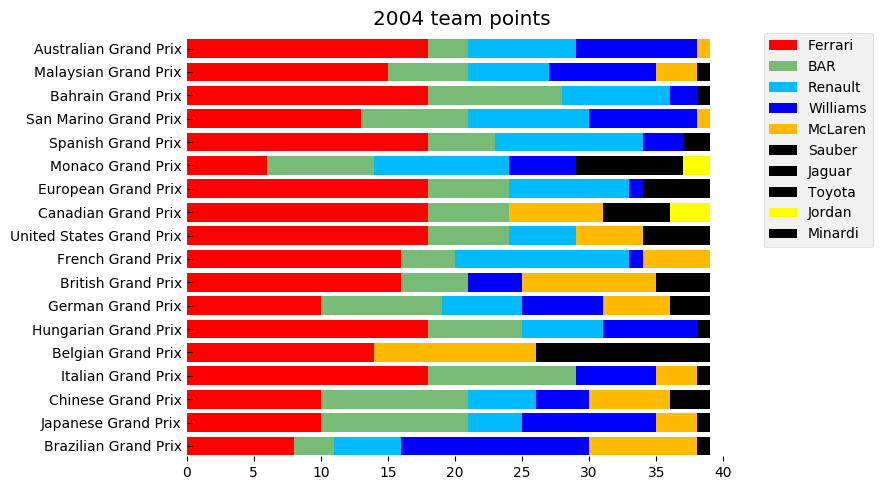

In [5]:
def top12in(year, **kwargs):

    data = (
        points.loc[lambda df: df['season'].eq(year)]
        .groupby('race team'.split(), sort=False)
        ['points'].sum().unstack('team', fill_value=0)
    )    
    data = data[data.sum().nlargest(12).index]
    
    kwargs.setdefault('color', data.columns.map(color))
    kwargs.setdefault('title', f"{year} team points")
    plot.barh(data, **kwargs)

top12in(2004)